# Module 2. Training on Local Environment 
---

This hands-on lab fine-tunes a pre-trained Image Classification model stored in model zoo, and train purely without using SageMaker training instance.

***If you already have experience with Deep Learning training using PyTorch, you can skip this notebook and go straight to SageMaker training notebook. The main purpose of this notebook is to show that SageMaker is a Docker container based and you can easily move your training code to SageMaker with just a few lines of code.***

This hands-on can be completed in about **20 minutes**. 

<div class="alert alert-info"><h4>Note</h4><p>It is recommended to use a GPU instance including <b>g4dn.xlarge, and p3.2xlarge</b> for this notebook. It also works on a CPU instance, but it can take 10-15 minutes to train just one epoch.</p></div>

In [1]:
%store -r
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import logging
import IPython

try:
    bucket 
    dataset_dir        
    print("[OK] You can proceed.")
except NameError:
    print("+"*60)
    print("[ERROR] Please run '01_make_augmented_imgs.ipynb' before you continue.")
    print("+"*60)

[OK] You can proceed.


In [2]:
%store

Stored variables and their in-db values:
base_model_name              -> 'mobilenetv2'
bucket                       -> 'sagemaker-us-east-1-143656149352'
classes                      -> ['brown_abnormal_chinese', 'brown_abnormal_korean'
dataset_dir                  -> 'bioplus'
local_model_path             -> '/opt/ml/model'
model_name                   -> 'model_best.pth'
num_classes                  -> 7
raw_dir                      -> 'raw'


<br>

# 1. Preparation
---

Environment variables that start with `SM_` are SageMaker environment variables, which are automatically set when you create a SageMaker training instance. We recommend using the `sagemaker-training-toolkit` when configuring your own containers (aka. BYOC; Bring Your Own Container).
For reference, the path of the SageMaker training Docker container is as follows.

```
/opt/ml/
    input/
        config/
        data/
    model/
    output/
        failure/
```

For example, `SM_MODEL_DIR` corresponds to `/opt/ml/model`. When testing locally, you can designate your own folder instead. When testing Docker containers, it is recommended to map bind mount volumes as in the example below.

```shell
docker run --mount type=bind,source=./model,target=/opt/ml/model [YOUR IMAGE TAG]

```

In [3]:
sys.path.append('./src/')

import copy
import time
import numpy as np
import torch, os
import torchvision
import json
import argparse
import matplotlib.pyplot as plt
import src.train_utils as train_utils
import src.train_single_gpu as train

num_gpus = 1 if torch.cuda.is_available() else 0
device = torch.device("cuda:0" if num_gpus == 1 else "cpu")

In [5]:
src_dir = os.getcwd()
os.environ['SM_CURRENT_HOST'] = 'algo-1'
os.environ['SM_HOSTS'] = json.dumps(["algo-1"])
os.environ['SM_MODEL_DIR'] = '/opt/ml/model'
os.environ['SM_NUM_GPUS'] = str(1)
os.environ['SM_CHANNEL_TRAIN'] = f'{src_dir}/{dataset_dir}/train'
os.environ['SM_CHANNEL_VALID'] = f'{src_dir}/{dataset_dir}/valid'

args = train.parser_args(train_notebook=True)

In [6]:
args.use_cuda = args.num_gpus > 0
args.device = torch.device("cuda" if args.use_cuda else "cpu")
args.rank = 0
args.world_size = 1

args.classes, args.classes_dict = train_utils.get_classes(args.train_dir) 
args.num_classes = len(args.classes)

In [7]:
args.classes_dict

{0: 'brown_abnormal_chinese',
 1: 'brown_abnormal_korean',
 2: 'brown_normal_chinese',
 3: 'brown_normal_korean',
 4: 'no_box',
 5: 'red_abnormal',
 6: 'red_normal'}

In [8]:
dataloaders, transforms, train_sampler = train_utils.create_dataloaders(
    args.train_dir, args.valid_dir, rank=args.rank, 
    world_size=args.world_size, batch_size=args.batch_size,
    num_workers=args.num_workers
)

red_normal no_box red_abnormal brown_normal_korean no_box red_abnormal red_abnormal brown_normal_chinese no_box no_box brown_abnormal_korean red_normal no_box red_abnormal red_abnormal no_box no_box brown_normal_korean no_box brown_normal_korean brown_normal_korean no_box red_abnormal no_box brown_abnormal_korean brown_normal_korean brown_abnormal_chinese red_normal brown_abnormal_korean brown_normal_chinese brown_abnormal_korean brown_normal_chinese red_abnormal no_box brown_abnormal_chinese brown_normal_korean brown_abnormal_korean no_box red_abnormal red_normal red_abnormal red_abnormal red_abnormal red_normal no_box no_box brown_abnormal_chinese red_normal no_box no_box brown_abnormal_korean brown_abnormal_chinese brown_abnormal_chinese brown_abnormal_chinese no_box red_normal brown_normal_korean brown_abnormal_chinese brown_abnormal_korean no_box no_box brown_abnormal_chinese red_abnormal brown_normal_chinese red_abnormal red_normal red_abnormal brown_normal_korean no_box brown_ab

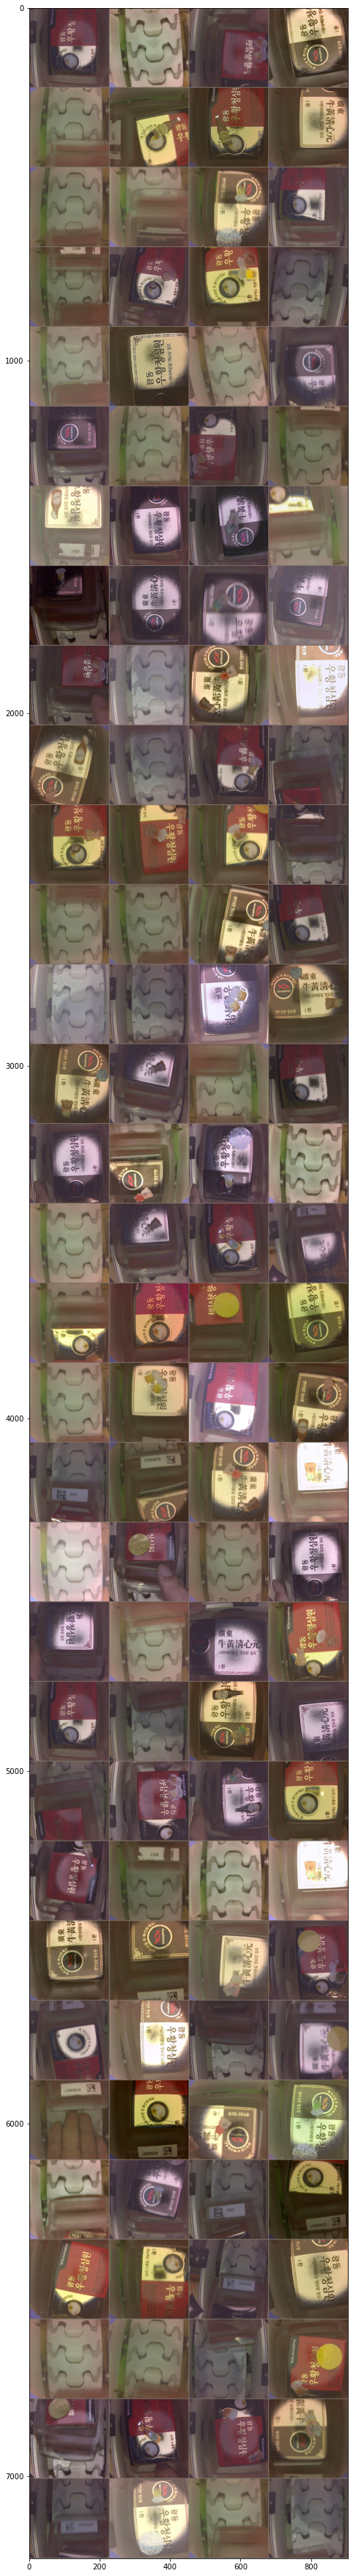

In [9]:
train_utils.visualize_dataloader_samples(dataloaders['train'], args.classes, nrow=4)

We recommend MobileNet-v2 or MnasNet among TorchVision's pre-trained models.

- MobileNet-V2 is built into TorchVision with an architecture that reduces the amount of computation by utilizing 1x1 convolution and Bottleneck Residual Block. Please note that TorchVision corresponding to the latest version of PyTorch also has built-in MobileNet-V3, but TorchVision corresponding to PyTorch 1.6.0 does not have built-in MobileNet-V3. (Paper: https://arxiv.org/pdf/1801.04381.pdf)

- MnasNet is a reinforcement learning-based neural architecture search that considers both accuracy and latency of mobile devices, and TorchVision has built-in MNasNet-B1 optimized for image classification.
(Paper: https://arxiv.org/pdf/1807.11626.pdf)

In [10]:
feature_extract = False
model = train_utils.initialize_ft_model(args.model_name, num_classes=args.num_classes, feature_extract=feature_extract)

<br>

# 2. Training Loop
---

Perform the main training loop. The script code is pre-configured for easy migration to the SageMaker environment.

In [11]:
%%writefile src/train_single_gpu.py
import os
import json
import random
import warnings
import logging
import sys
import train_utils
import copy
import time
import argparse
from typing import Tuple
from tqdm import tqdm
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch import nn, optim
from torch.distributed import Backend
from torch.utils.data import DataLoader, DistributedSampler
from torchvision import datasets, transforms
logger = train_utils.set_logger()

        
def parser_args(train_notebook=False):
    parser = argparse.ArgumentParser()

    # Default Setting
    parser.add_argument('--log_interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')

    # Hyperparameter Setting
    parser.add_argument('--model_name', type=str, default='mobilenetv2')
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--num_epochs', type=int, default=10)
    parser.add_argument('--batch_size', type=int, default=128)

    # SageMaker Container environment
    parser.add_argument('--hosts', type=list,
                        default=json.loads(os.environ['SM_HOSTS']))
    parser.add_argument('--current_host', type=str,
                        default=os.environ['SM_CURRENT_HOST'])
    parser.add_argument('--model_dir', type=str,
                        default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--model_chkpt_dir', type=str,
                        default='/opt/ml/checkpoints')    
    parser.add_argument('--train_dir', type=str,
                        default=os.environ['SM_CHANNEL_TRAIN'])
    parser.add_argument('--valid_dir', type=str,
                        default=os.environ['SM_CHANNEL_VALID'])    
    parser.add_argument('--num_gpus', type=int,
                        default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--output_data_dir', type=str,
                        default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    
    if train_notebook:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args


def trainer(current_gpu, model, dataloaders, transforms, args):
    
    batch_size = args.batch_size
    num_epochs = args.num_epochs
    feature_extract = False    
    
    optimizer = train_utils.initialize_optimizer(model, feature_extract, lr=1e-3, momentum=0.9)    
    criterion = nn.CrossEntropyLoss()

    # Send the model to GPU
    model = model.to(args.device)
    
    since = time.time()
    best_acc1 = 0.0

    num_samples = {k: len(dataloaders[k].dataset) for k, v in dataloaders.items()}
    num_steps = {k: int(np.ceil(len(dataloaders[k].dataset) / (batch_size))) for k, v in dataloaders.items()}

    for epoch in range(1, num_epochs+1):

        batch_time = train_utils.AverageMeter('Time', ':6.3f')
        data_time = train_utils.AverageMeter('Data', ':6.3f')
        losses = train_utils.AverageMeter('Loss', ':.4e')
        top1 = train_utils.AverageMeter('Acc@1', ':6.2f')

        logger.info('-' * 40)
        logger.info('[Epoch {}/{}] Processing...'.format(epoch, num_epochs))
        logger.info('-' * 40)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_tic = time.time()            
            tic = time.time()        

            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                # measure data loading time
                data_time.update(time.time() - tic)

                inputs = inputs.to(args.device)
                labels = labels.to(args.device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    probs, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                acc1 = train_utils.accuracy(outputs, labels, topk=(1,)) 

                losses.update(train_utils.to_python_float(loss.data), inputs.size(0))
                top1.update(train_utils.to_python_float(acc1[0]), inputs.size(0))
                batch_time.update(time.time() - tic)
                tic = time.time()

                if phase == 'train' and i % 10 == 0:
                    step_loss = running_loss / ((i+1)*inputs.size(0))
                    step_acc = running_corrects.double() / ((i+1)*inputs.size(0))

                    logger.info(f'[Epoch {epoch}/{num_epochs}, Step {i+1}/{num_steps[phase]}] {phase}-acc: {step_acc:.4f}, '
                             f'{phase}-loss: {step_loss:.4f}, data-time: {data_time.val:.4f}, batch-time: {batch_time.val:.4f}')            

            logger.info(f'[Epoch {epoch}/{num_epochs}] {phase}-acc: {top1.avg:.4f}, '
                         f'{phase}-loss: {losses.val:.4f}, time: {time.time()-epoch_tic:.4f}') 

            if phase == 'valid':
                is_best = top1.avg > best_acc1
                best_acc1 = max(top1.avg, best_acc1)

                train_utils.save_model({
                    'epoch': epoch + 1,
                    'model_name': args.model_name,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'best_acc1': best_acc1,
                    'loss': losses
                }, is_best, args.model_chkpt_dir, args.model_dir)                 

    time_elapsed = time.time() - since
    logger.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    logger.info('Best val acc: {:.4f}'.format(best_acc1))    
    
    
if __name__ == '__main__':
    
    is_sm_container = True    
    if os.environ.get('SM_CURRENT_HOST') is None:
        is_sm_container = False
        
        src_dir = '/'.join(os.getcwd().split('/')[:-1])
        os.environ['SM_CURRENT_HOST'] = 'algo-1'
        os.environ['SM_HOSTS'] = json.dumps(["algo-1"])
        os.environ['SM_MODEL_DIR'] = f'{src_dir}/model'
        os.environ['SM_NUM_GPUS'] = str(1)
        dataset_dir = f'{src_dir}/smartfactory'
        os.environ['SM_CHANNEL_TRAIN'] = f'{dataset_dir}/train'
        os.environ['SM_CHANNEL_VALID'] = f'{dataset_dir}/valid'  
        
    args = parser_args()
    args.use_cuda = args.num_gpus > 0
    
    print("args.use_cuda : {} , args.num_gpus : {}".format(
        args.use_cuda, args.num_gpus))
    args.kwargs = {'pin_memory': True} if args.use_cuda else {}
    args.device = torch.device("cuda" if args.use_cuda else "cpu")
    args.rank = 0
    args.world_size = 1
        
    os.makedirs(args.model_chkpt_dir, exist_ok=True)
    os.makedirs(args.model_dir, exist_ok=True)

    args.classes, args.classes_dict = train_utils.get_classes(args.train_dir) 
    args.num_classes = len(args.classes)
    
    dataloaders, transforms, train_sampler = train_utils.create_dataloaders(
        args.train_dir, args.valid_dir, rank=args.rank, 
        world_size=args.world_size, batch_size=args.batch_size,
        num_workers=args.num_workers
    )

    feature_extract = False
    model = train_utils.initialize_ft_model(args.model_name, num_classes=args.num_classes, feature_extract=feature_extract)

    trainer(0, model, dataloaders, transforms, args)

Overwriting src/train_single_gpu.py


In [12]:
%%bash
sudo rm -rf /opt/ml/model /opt/ml/checkpoints
sudo mkdir -p /opt/ml/model
sudo mkdir -p /opt/ml/checkpoints
sudo chown ec2-user:ec2-user -R /opt/ml/model
sudo chown ec2-user:ec2-user -R /opt/ml/checkpoints

In [14]:
%%time
train.trainer(0, model, dataloaders, transforms, args)

=== Params to learn ===
features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.conv.0.0.weight
features.1.conv.0.1.weight
features.1.conv.0.1.bias
features.1.conv.1.weight
features.1.conv.2.weight
features.1.conv.2.bias
features.2.conv.0.0.weight
features.2.conv.0.1.weight
features.2.conv.0.1.bias
features.2.conv.1.0.weight
features.2.conv.1.1.weight
features.2.conv.1.1.bias
features.2.conv.2.weight
features.2.conv.3.weight
features.2.conv.3.bias
features.3.conv.0.0.weight
features.3.conv.0.1.weight
features.3.conv.0.1.bias
features.3.conv.1.0.weight
features.3.conv.1.1.weight
features.3.conv.1.1.bias
features.3.conv.2.weight
features.3.conv.3.weight
features.3.conv.3.bias
features.4.conv.0.0.weight
features.4.conv.0.1.weight
features.4.conv.0.1.bias
features.4.conv.1.0.weight
features.4.conv.1.1.weight
features.4.conv.1.1.bias
features.4.conv.2.weight
features.4.conv.3.weight
features.4.conv.3.bias
features.5.conv.0.0.weight
features.5.conv.0.1.weight
features.5.conv.0.1

2021-08-23 11:37:48 [INFO] train_utils - [Epoch 6/10, Step 11/12] train-acc: 0.9240, train-loss: 0.4002, data-time: 0.0000, batch-time: 0.4328
2021-08-23 11:37:48 [INFO] train_utils - [Epoch 6/10] train-acc: 0.9239, train-loss: 0.3411, time: 6.1754
2021-08-23 11:37:49 [INFO] train_utils - [Epoch 6/10] valid-acc: 0.9035, valid-loss: 0.3575, time: 1.4414
Saving the model.
2021-08-23 11:37:50 [INFO] train_utils - ----------------------------------------
2021-08-23 11:37:50 [INFO] train_utils - [Epoch 7/10] Processing...
2021-08-23 11:37:50 [INFO] train_utils - ----------------------------------------
2021-08-23 11:37:51 [INFO] train_utils - [Epoch 7/10, Step 1/12] train-acc: 0.9531, train-loss: 0.3277, data-time: 1.0785, batch-time: 1.5091
2021-08-23 11:37:56 [INFO] train_utils - [Epoch 7/10, Step 11/12] train-acc: 0.9439, train-loss: 0.3258, data-time: 0.0000, batch-time: 0.4322
2021-08-23 11:37:56 [INFO] train_utils - [Epoch 7/10] train-acc: 0.9418, train-loss: 0.2849, time: 6.2113
2021

<br>

## 2. Check for Validation Data
---

Try performing inference on the validation dataset in mini-batch.

In [15]:
model_name = 'model_best.pth'
chkpt = torch.load(os.path.join(args.model_dir, model_name))
model.load_state_dict(chkpt['state_dict'])

<All keys matched successfully>

In [16]:
# model = model.to(args.device)

<Figure size 432x288 with 0 Axes>

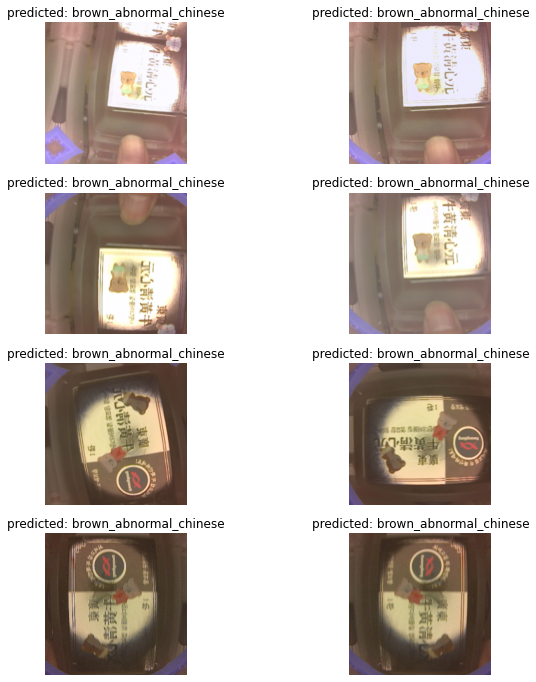

In [17]:
model.eval()
images_so_far = 0
fig = plt.figure()
num_images = 8
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        plt.figure(figsize=(10, 12)) 
        for j in range(num_images):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(args.classes[preds[j]]))
            
            m = inputs.cpu().data[j]
            inv_normalize = train_utils.create_inv_transform()
            m = inv_normalize(m)
            
            m = np.transpose(m.numpy(), (1,2,0))
            m = np.clip(m, 0, 1)     
            plt.imshow(m)
        break

In [18]:
local_model_path = args.model_dir
base_model_name = args.model_name
%store base_model_name local_model_path model_name

Stored 'base_model_name' (str)
Stored 'local_model_path' (str)
Stored 'model_name' (str)


<br>

# Next Step

In this session, the model was trained in the local environment without invoking the SageMaker Training job. If you need hands-on practice with SageMaker training, continue with `03_sm_training.ipynb`. If you have a greater need for how to compile and deploy a trained model to a target edge device than SageMaker training, skip `03_sm_training.ipynb` and proceed to `04_neo_compile_deploy.ipynb`.